> [Amanda L Richer, Kent A Riemondy, Lakotah Hardie, Jay R Hesselberth, **Simultaneous measurement of biochemical phenotypes and gene expression in single cells**, *Nucleic Acids Research*, (2020)](https://doi.org/10.1093/nar/gkaa240)

> **Dataset:** Cell line models targeted with CRISPR technology and UNG<sup>KO</sup> and RNASEH2C<sup>KO</sup> used for single cell RNA experssion experiments (haicut-seq) in 3 timepoints. 
> - **Cell line:** Hap1 UNG<sup>KO</sup> (HZGHC001531c012) and RNASEH2C<sup>KO</sup> (HZGHC004633c003) cells.


**Aim:** 

# Differential analysis 

> Many methods have been used to determine differential gene expression from single-cell RNA (scRNA)-seq data. 

> Prefiltering of lowly expressed genes has important effects, particularly for some of the methods developed for bulk RNA-seq data analysis. However, we found that bulk RNA-seq analysis methods do not generally perform worse than those developed specifically for scRNA-seq. 

Source: [Soneson, C., Robinson, M. Bias, **robustness and scalability in single-cell differential expression analysis.** Nat Methods 15, 255–261 (2018).](https://doi.org/10.1038/nmeth.4612)

Also see 
[Wang, T., Li, B., Nelson, C.E. et al. **Comparative analysis of differential gene expression analysis tools for single-cell RNA sequencing data.** BMC Bioinformatics 20, 40 (2019).](https://doi.org/10.1186/s12859-019-2599-6)


[course chapter 12: Differential Expression (DE) analysis](https://biocellgen-public.svi.edu.au/mig_2019_scrnaseq-workshop/public/dechapter.html)


I'm also discussing this topic here https://github.com/abearab/sc-haircut-net/issues/3#issuecomment-832263091

## workflow
<img src="https://hbctraining.github.io/scRNA-seq/img/de_workflow_salmon.png" width="250" align="center"/>




<!-- https://github.com/theislab/diffxpy

https://diffxpy.readthedocs.io/en/latest/tutorials.html

https://nbviewer.jupyter.org/github/theislab/diffxpy_tutorials/blob/master/diffxpy_tutorials/test/introduction_differential_testing.ipynb

https://github.com/markrobinsonuzh/conquer

https://hbctraining.github.io/scRNA-seq/lessons/pseudobulk_DESeq2_scrnaseq.html

-->

### `DESeq2` 
<img src="https://hbctraining.github.io/scRNA-seq/img/de_workflow_salmon_deseq1.png" width="350" align="center"/>

> ### Estimate dispersion and DE using `DESeq2`
> Van den Berge and Perraudeau and others have shown the LRT may perform better for null hypothesis testing, so we use the LRT. In order to use the Wald test, it is recommended to set `useT=TRUE`.

> ### Plot dispersion estimates
> It is recommended to plot the dispersion estimates for DESeq2 on single-cell data. As discussed in the DESeq2 paper, it becomes difficult to accurately estimate the dispersion when the counts are very small, because the Poisson component of the variance is dominant. Therefore we see some very low dispersion estimates here, although the trend is still accurately capturing the upper proportion. So here everything looks good.


> If the parametric trend fails to fit (there would be a warning in this case), one should check the dispersion plot as above. If it looks like the dispersion fit is being thrown off by the low count genes with low dispersion estimates at the bottom of the plot, there is a relatively easy solution: one can filter out more of the low count genes only for the dispersion estimation step, so that the trend still captures the upper portion. This is pretty easy to do in DESeq2, to filter genes solely for the dispersion trend estimation, but to use a larger set for the rest of the analysis. An example of how this can be done:


In [1]:
%load_ext rpy2.ipython

In [2]:
%%R 
suppressPackageStartupMessages(library(SingleCellExperiment))
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(DESeq2))
suppressPackageStartupMessages(library(scran))
suppressPackageStartupMessages(library(zinbwave))
suppressPackageStartupMessages(library(BiocParallel))
suppressPackageStartupMessages(library(ggrepel))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(patchwork))

In [3]:
import scanpy as sc

mix = sc.read_h5ad('preprocessing/mix.h5ad.gz')

In [62]:
counts = mix.to_df().T
meta = mix.obs

In [63]:
%%R -i counts,meta
sce <- sce_prep (counts,meta)
remove(counts)
remove(meta)

In [64]:
%%R 
sce$time <- factor (sce$time)
sce$time <- relevel(sce$time, ref="15")

sce$rG <- factor(sce$'riboG-repair', ordered = FALSE)
sce$rG <- relevel(sce$rG, ref="low")

sce$dU <- factor(sce$'Uracil-repair', ordered = FALSE) 
sce$dU <- relevel(sce$dU, ref="low")
sce

class: SingleCellExperiment 
dim: 1527 4865 
metadata(0):
assays(1): counts
rownames(1527): ISG15 AURKAIP1 ... MT-ND6 MT-CYB
rowData names(0):
colnames(4865): AAACCTGAGATCCTGT-0 AAACGGGAGGTTCCTA-0 ...
  TATCTCAGTGATGTCT-2 CTCCTAGGTTCATGGT-2
colData names(7): time Uracil-45 ... rG dU
reducedDimNames(0):
altExpNames(0):


In [65]:
%%R 
saveRDS(sce, 'deseq/sce.rds')

In [4]:
%%R 
sce <- readRDS('deseq/sce.rds')

In [63]:
%%R 
sce_prep <- function (counts,meta){
    ### Load data as `SingleCellExperiment` object 
    sce <- SingleCellExperiment(list(counts=counts),colData=meta)
    
    ### low count filter - at least 10 cells with count of 5 or more
    keep <- rowSums(counts(sce) >= 5) >= 10 
    sce <- sce[keep,] 
    
    assay(sce) <- as.matrix(assay(sce))

    return (sce)
}

runDESeq <- function (sce,design){
    
    ### make DESeqDataSet object
    dds <- DESeqDataSet(sce, design = design) # https://support.bioconductor.org/p/64480/#64576

    ### Estimate size factors
    dds <- estimateSizeFactors(dds, type="poscounts")
    scr <- computeSumFactors(dds)
    # use scran's sum factors:
    sizeFactors(dds) <- sizeFactors(scr)

    ### Run DESeq Test (Annova like test ?)
    system.time({
      dds <- DESeq(dds, test="LRT", reduced=~1,
                   minmu=1e-6, minRep=Inf)#, parallel=TRUE) 
    })
    
    print (resultsNames(dds))
    
    return (dds)
}

plot_Volcano <- function(res, lfc.cutoff  = 1,pval.cutoff = 0.05, title='', x_min=-20,x_max=20, y_max=FALSE){
    res$sig <- as.factor(res$pvalue < pval.cutoff & abs(res$log2FoldChange) > lfc.cutoff)
    relevel(res$sig, ref=TRUE)
    
    data = subset(res[order(res$pvalue),], sig == TRUE)[1:7,]
    
    if (y_max == FALSE){-log10(min(res$pvalue))}
    
    vol = res %>% ggplot(
        aes(x=log2FoldChange, y=-log10(pvalue), colour=sig, fill=sig)) +
        geom_point(aes(color = sig),alpha = 1/10) +
            geom_hline(yintercept=-log10(pval.cutoff), linetype="dashed", alpha = 4/10) +
            geom_vline(xintercept=lfc.cutoff, linetype="dashed", alpha = 4/10) +
            geom_vline(xintercept=(-1)*lfc.cutoff, linetype="dashed", alpha = 4/10) +
            scale_color_manual(values = c("grey", "red")) +
            theme_bw() + 
            theme(legend.position="none") +
            ggtitle (title) + 
            geom_text_repel(
                data = data,
                aes(label = rownames(data)),
                size = 3,
                box.padding = unit(0.35, "lines"),
                point.padding = unit(0.3, "lines")
            ) + 
            xlim(c(x_min,x_max)) +
            if (y_max != FALSE){ylim(c(0,y_max))}

     return (vol)
} 

plotDisp <- function(dds){
    p1 = plotDispEsts(dds)
    keepForDispTrend <- rowSums(counts(dds) >= 10) >= 25
    dds2 <- estimateDispersionsFit(dds[keepForDispTrend,])
    p2 = plotDispEsts(dds2, ylim=c(1e-3,1))
}

plot_PCA <- function(vsd, gr, title,legend='none'){
    colData <- colData(vsd)
    z <- plotPCA(vsd,intgroup=gr, returnData=TRUE)
    percentVar <- round(100 * attr(z, "percentVar"))
    pca <- ggplot(z, aes(PC1, PC2)) + 
            geom_point(aes(size = 0.01, colour=group,fill=group), alpha = 0.4,shape=18) +
            xlab(paste0("PC1: ",percentVar[1],"% variance")) +
            ylab(paste0("PC2: ",percentVar[2],"% variance")) +
            guides (size = FALSE) +
            ggtitle (title)+ 
            theme(legend.position=legend)
    return (pca)
}

correct_batch <- function (dds,gr,out){
    vsd <- varianceStabilizingTransformation(dds, blind=FALSE)
    p0 <- plot_PCA(vsd, gr, 'Before removeBatchEffect')
    mat <- assay(vsd)
    
    mat <- limma::removeBatchEffect(mat, vsd$time) # batch is same as time 
    assay(vsd) <- mat
    p1 <- plot_PCA(vsd, gr, 'After removeBatchEffect',legend='right')
    counts_batch_corrected <- assay(vsd)
    
    if (out == 'plot'){return (p0 + p1)}
    if (out == 'vsd') {return (vsd)}
    if (out == 'cbc') {return (counts_batch_corrected)}
} 

In [6]:
%%R 
sce$time <- factor (sce$time)
sce$time <- relevel(sce$time, ref="15")

sce$rG <- factor(sce$'riboG-repair', ordered = FALSE)
sce$rG <- relevel(sce$rG, ref="low")

sce$dU <- factor(sce$'Uracil-repair', ordered = FALSE) 
sce$dU <- relevel(sce$dU, ref="low")
sce

class: SingleCellExperiment 
dim: 1527 4865 
metadata(0):
assays(1): counts
rownames(1527): ISG15 AURKAIP1 ... MT-ND6 MT-CYB
rowData names(0):
colnames(4865): AAACCTGAGATCCTGT-0 AAACGGGAGGTTCCTA-0 ...
  TATCTCAGTGATGTCT-2 CTCCTAGGTTCATGGT-2
colData names(7): time Uracil-45 ... rG dU
reducedDimNames(0):
altExpNames(0):


Define independent variables and make `DESeq` object:

In [70]:
%%R 
dds_all = runDESeq(sce, ~time + rG+dU)
saveRDS(dds_all, 'deseq/dds_all.rds')
remove(dds_all)

R[write to console]: converting counts to integer mode

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



[1] "Intercept"      "time_30_vs_15"  "time_60_vs_15"  "rG_high_vs_low"
[5] "rG_none_vs_low" "dU_high_vs_low" "dU_none_vs_low"


In [7]:
%%R 
dds_all <- readRDS('deseq/dds_all.rds') 

In [130]:
%%R -o cbc,ncu
cbc <- correct_batch(dds_all,c('time'),'cbc') %>% data.frame

ncu <- counts(dds_all, normalized=TRUE) %>% data.frame

Save normalized counts:

In [120]:
cbc.to_csv('deseq/counts_batch_corrected.txt.gz', compression='gzip')

In [121]:
ncu.to_csv('deseq/counts_normalized.txt.gz', compression='gzip')

____
Here we aim to test and report multiple differential expression settings in our dataset:
- rG high vs. rG low in 15 minutes 
- rG high vs. rG low in 30 minutes 
- rG high vs. rG low in 60 minutes 
- rG high in 60 minutes vs. rG high in 15 minutes 


- dU high vs. dU low in 15 minutes 
- dU high vs. dU low in 30 minutes 
- dU high vs. dU low in 60 minutes 
- dU high in 60 minutes vs. dU high in 15 minutes 


# rG high vs. rG low

In [33]:
%%R 
sce_rG = sce[,!sce$rG == 'none']

In [181]:
%%R 
sce_rG = sce[,!sce$rG == 'none']
sce_rG$rG = factor(sce_rG$rG)

dds_rG = runDESeq(sce_rG, ~rG+time+rG:time )
saveRDS(dds_rG, 'deseq/dds_rG.rds')
remove(dds_rG)

R[write to console]: converting counts to integer mode

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



[1] "Intercept"      "rG_high_vs_low" "time_30_vs_15"  "time_60_vs_15" 
[5] "rGhigh.time30"  "rGhigh.time60" 


In [8]:
%%R 
dds_rG <- readRDS('deseq/dds_rG.rds')

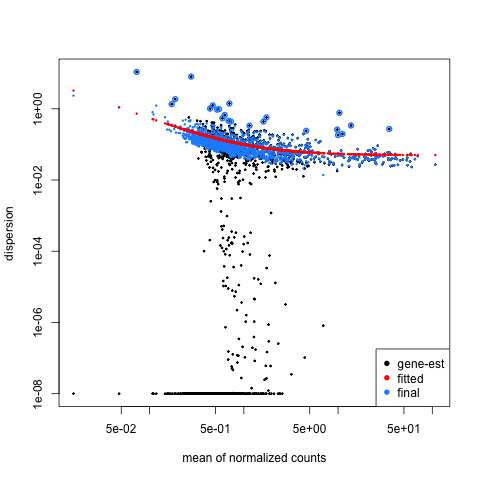

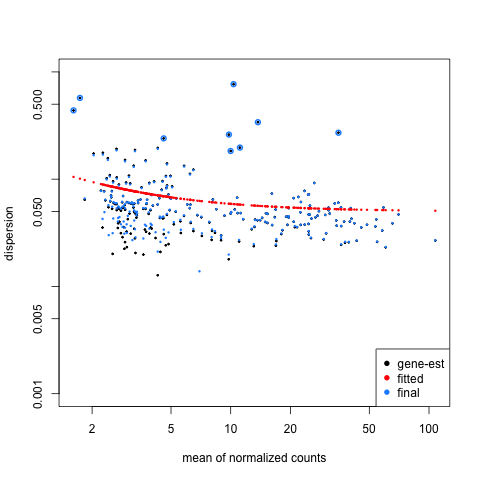

In [187]:
%%R 
plotDisp(dds_rG)

#### PCA - removeBatchEffect

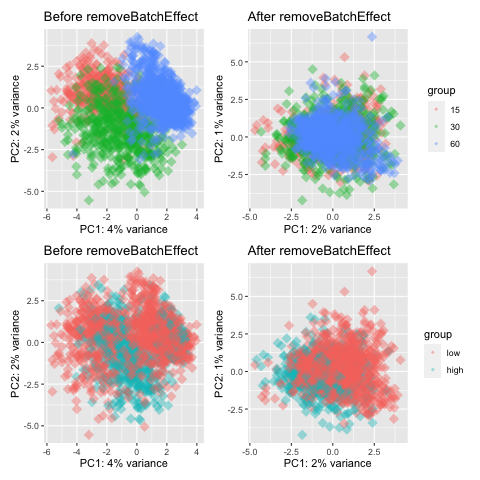

In [24]:
%%R 
correct_batch(dds_rG,c('time'),'plot') / correct_batch(dds_rG,c('rG'),'plot')

Replace counts with correct counts after removing batch effect:

In [189]:
%%R 
assay(dds_rG) <- correct_batch(dds_rG,'time','cbc') 

In [190]:
%%R 
resultsNames(dds_rG)

[1] "Intercept"      "rG_high_vs_low" "time_30_vs_15"  "time_60_vs_15" 
[5] "rGhigh.time30"  "rGhigh.time60" 


In [191]:
%%R -o rG_15,rG_30,rG_60
rG_15 <- results(dds_rG, name="rG_high_vs_low", independentFiltering=FALSE)  %>% 
    data.frame %>% 
    relocate(log2FoldChange)

rG_30 <- results(dds_rG, contrast=list("rG_high_vs_low", "rGhigh.time30"), independentFiltering=FALSE)  %>% 
    data.frame %>% 
    relocate(log2FoldChange)

rG_60 <- results(dds_rG, contrast=list("rG_high_vs_low", "rGhigh.time60"), independentFiltering=FALSE)  %>% 
    data.frame %>% 
    relocate(log2FoldChange)

Extract results table.


In [192]:
rG_15.to_csv('deseq/delta_rG_15.txt',sep='\t')
rG_30.to_csv('deseq/delta_rG_30.txt',sep='\t')
rG_60.to_csv('deseq/delta_rG_60.txt',sep='\t')

# rG high at 60' vs. rG high at 15'

In [195]:
%%R -o rG_60_vs_15
rG_60_vs_15 <- results(dds_rG, contrast=list("time_60_vs_15","rGhigh.time60"), independentFiltering=FALSE)  %>% 
    data.frame %>% 
    relocate(log2FoldChange)

In [196]:
rG_60_vs_15.to_csv('deseq/delta_rG_60_vs_15.txt',sep='\t')

Volcano-plots:

In [47]:
import pandas as pd
rG_60_vs_15 = pd.read_csv('deseq/delta_rG_60_vs_15.txt',index_col=0,sep='\t')
rG_15 = pd.read_csv('deseq/delta_rG_15.txt',index_col=0,sep='\t')
rG_30 = pd.read_csv('deseq/delta_rG_30.txt',index_col=0,sep='\t')
rG_60 = pd.read_csv('deseq/delta_rG_60.txt',index_col=0,sep='\t')

In [65]:
%%R -i rG_15,rG_30,rG_60
g15 <- plot_Volcano(rG_15,y_max=200,x_min=-5, x_max=5,title='rG @15\'')
g30 <- plot_Volcano(rG_30,y_max=200,x_min=-5, x_max=5,title='rG @30\'')
g60 <- plot_Volcano(rG_60,y_max=200,x_min=-5, x_max=5,title='rG @60\'')

In [66]:
%%R -i rG_60_vs_15
g60vs15 = plot_Volcano(rG_60_vs_15,y_max=900,x_min=-5, x_max=5,title='rG+ @60\' vs rG+ @15\'')

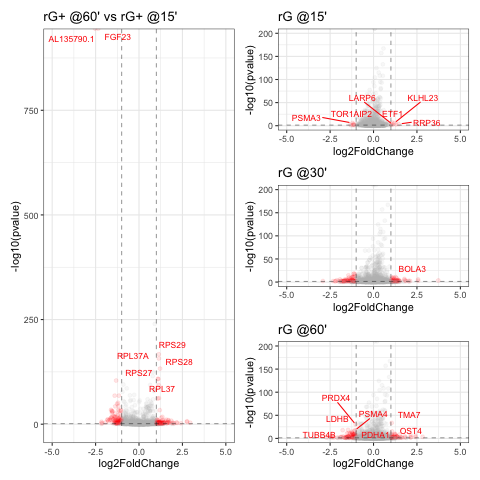

In [67]:
%%R 
g = g60vs15+(g15/g30/g60)
g

In [200]:
%%R 
ggsave('deseq/rG.pdf',g)

R[write to console]: Saving 6.67 x 6.67 in image



# dU+ vs. dU-

In [73]:
%%R 
sce_dU = sce[,!sce$dU == 'none']
sce_dU$dU = factor(sce_dU$dU)

dds_dU = runDESeq(sce_dU, ~dU+time+dU:time)
saveRDS(dds_dU, 'deseq/dds_dU.rds')
remove(dds_dU)

R[write to console]: converting counts to integer mode

R[write to console]: using pre-existing size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



[1] "Intercept"      "dU_high_vs_low" "time_30_vs_15"  "time_60_vs_15" 
[5] "dUhigh.time30"  "dUhigh.time60" 


In [25]:
%%R 
dds_dU <- readRDS('deseq/dds_dU.rds')

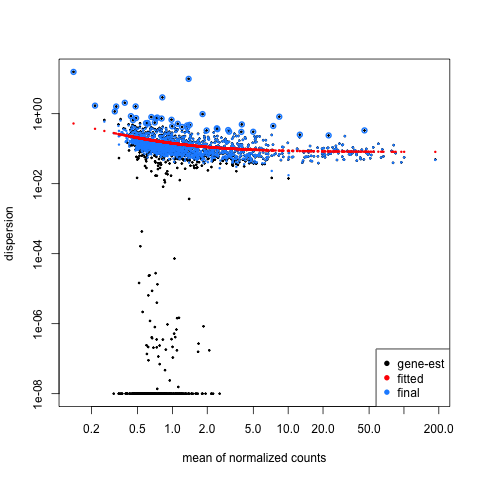

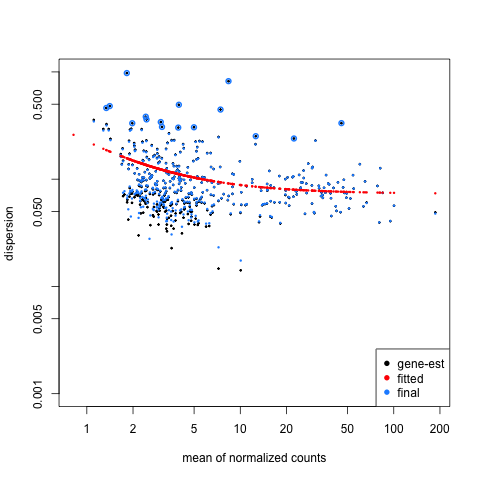

In [26]:
%%R 
plotDisp(dds_dU)

#### PCA - removeBatchEffect

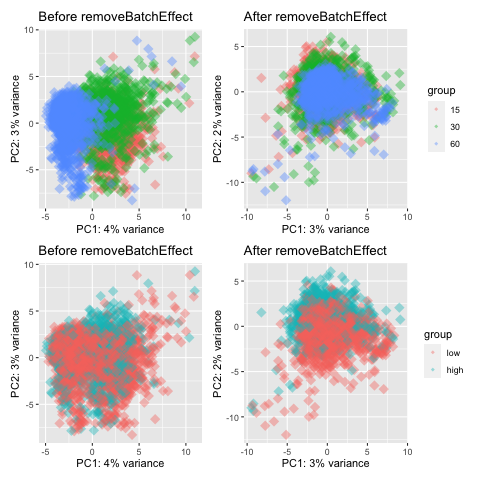

In [27]:
%%R 
correct_batch(dds_dU,c('time'),'plot') / correct_batch(dds_dU,c('dU'),'plot')

In [204]:
%%R 
counts(dds_dU)[1:3,1:3]

         AAACCTGAGATCCTGT-0 AAACGGGAGGTTCCTA-0 AAAGATGCAATAACGA-0
ISG15                     0                  0                  2
AURKAIP1                  7                  2                  5
MRPL20                    2                  0                  0


In [205]:
%%R 
assay(dds_dU) <- correct_batch(dds_dU,'time','cbc') 

In [206]:
%%R 
counts(dds_dU)[1:3,1:3]

         AAACCTGAGATCCTGT-0 AAACGGGAGGTTCCTA-0 AAAGATGCAATAACGA-0
ISG15              1.686631           1.686631           3.365246
AURKAIP1           4.299858           3.352135           4.010527
MRPL20             3.315507           1.680664           1.680664


In [207]:
%%R -o dU_15,dU_30,dU_60
dU_15 <- results(dds_dU, contrast=list("dU_high_vs_low"), independentFiltering=FALSE)  %>% 
    data.frame %>% 
    relocate(log2FoldChange)

dU_30 <- results(dds_dU, contrast=list("dU_high_vs_low", "dUhigh.time30"), independentFiltering=FALSE)  %>% 
    data.frame %>% 
    relocate(log2FoldChange)

dU_60 <- results(dds_dU, contrast=list("dU_high_vs_low", "dUhigh.time60"), independentFiltering=FALSE)  %>% 
    data.frame %>% 
    relocate(log2FoldChange)

Extract results table.


In [209]:
dU_15.to_csv('deseq/delta_dU_15.txt',sep='\t')
dU_30.to_csv('deseq/delta_dU_30.txt',sep='\t')
dU_60.to_csv('deseq/delta_dU_60.txt',sep='\t')

# dU+ at 60' vs. dU+ at 15'

In [210]:
%%R -o dU_60_vs_15
dU_60_vs_15 <- results(dds_dU, contrast=list("time_60_vs_15",'dUhigh.time60'), independentFiltering=FALSE)  %>% 
    data.frame %>% 
    relocate(log2FoldChange)

In [211]:
dU_60_vs_15.to_csv('deseq/delta_dU_60_vs_15.txt',sep='\t')

Volcano-plots:

In [58]:
import pandas as pd
dU_60_vs_15 = pd.read_csv('deseq/delta_dU_60_vs_15.txt',index_col=0,sep='\t')
dU_15 = pd.read_csv('deseq/delta_dU_15.txt',index_col=0,sep='\t')
dU_30 = pd.read_csv('deseq/delta_dU_30.txt',index_col=0,sep='\t')
dU_60 = pd.read_csv('deseq/delta_dU_60.txt',index_col=0,sep='\t')

In [68]:
%%R -i dU_15,dU_30,dU_60
u15 <- plot_Volcano(dU_15,y_max=300,x_min = -5, x_max = 5,title='dU @15\'')
u30 <- plot_Volcano(dU_30,y_max=300,x_min = -5, x_max = 5,title='dU @30\'')
u60 <- plot_Volcano(dU_60,y_max=300,x_min = -5, x_max = 5,title='dU @60\'')

In [69]:
%%R -i dU_60_vs_15
u60vs15 = plot_Volcano(dU_60_vs_15,y_max=900,x_min=-5, x_max=5,title='dU+ @60\' vs dU+ @15\'')

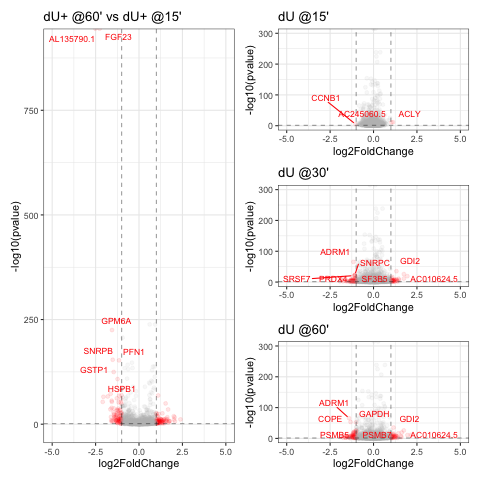

In [70]:
%%R 
u = u60vs15+(u15/u30/u60)
u

In [214]:
%%R 
ggsave('deseq/dU.pdf',u)

R[write to console]: Saving 6.67 x 6.67 in image



___

In [97]:
%%R 
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Catalina 10.15.7

Matrix products: default
BLAS:   /System/Library/Frameworks/Accelerate.framework/Versions/A/Frameworks/vecLib.framework/Versions/A/libBLAS.dylib
LAPACK: /Users/abearab/anaconda3/envs/sc-analysis/lib/liblapack.3.9.0.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
 [1] parallel  stats4    tools     stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] patchwork_1.1.1             ggrepel_0.9.1              
 [3] BiocParallel_1.24.1         zinbwave_1.12.0            
 [5] scran_1.18.5                DESeq2_1.30.1              
 [7] forcats_0.5.1               stringr_1.4.0              
 [9] dplyr_1.0.5                 purrr_0.3.4                
[11] readr_1.4.0                 tidyr_1.1.3                
[13] tibble_3.1.1                ggplot2_3.3.3              
[15